## Intro

This notebook implements solutions for the Decision-making under Uncertainty (DMUU) assignment focused on energy hub optimization. We'll develop and evaluate different optimization strategies to manage an energy hub with renewable generation (wind), hydrogen storage, and grid connections under uncertainty.

In [2]:
# ============================================
# || Import all necessary libraries         ||
# ============================================

# Standard libraries
import random
import time
import pickle
import numpy as np

# Utilities
from utils.data import get_fixed_data
from utils.visualization import (
    plot_results,
    plot_experiment_results,
    plot_cost_histogram,
    compare_policies,
)

# Task-specific imports
from task_0.helper_functions import generate_trajectories, solve_milp
from task_1.evaluation_framework import evaluate_policy, create_experiments
from task_1.energy_hub_policies import dummy_policy
from task_2.helper_functions import create_ev_policy, create_sp_policy
from task_3.adp_final import adp_policy_final


## Task 0: Optimal in Hindsight Solution

In this task, we implement a Mixed-Integer Linear Programming (MILP) solution for the energy hub management problem assuming perfect knowledge of future wind power generation and electricity prices. This "optimal in hindsight" solution provides a theoretical performance benchmark (lower bound on cost) that real-world policies cannot exceed.

Optimal cost: 442.75


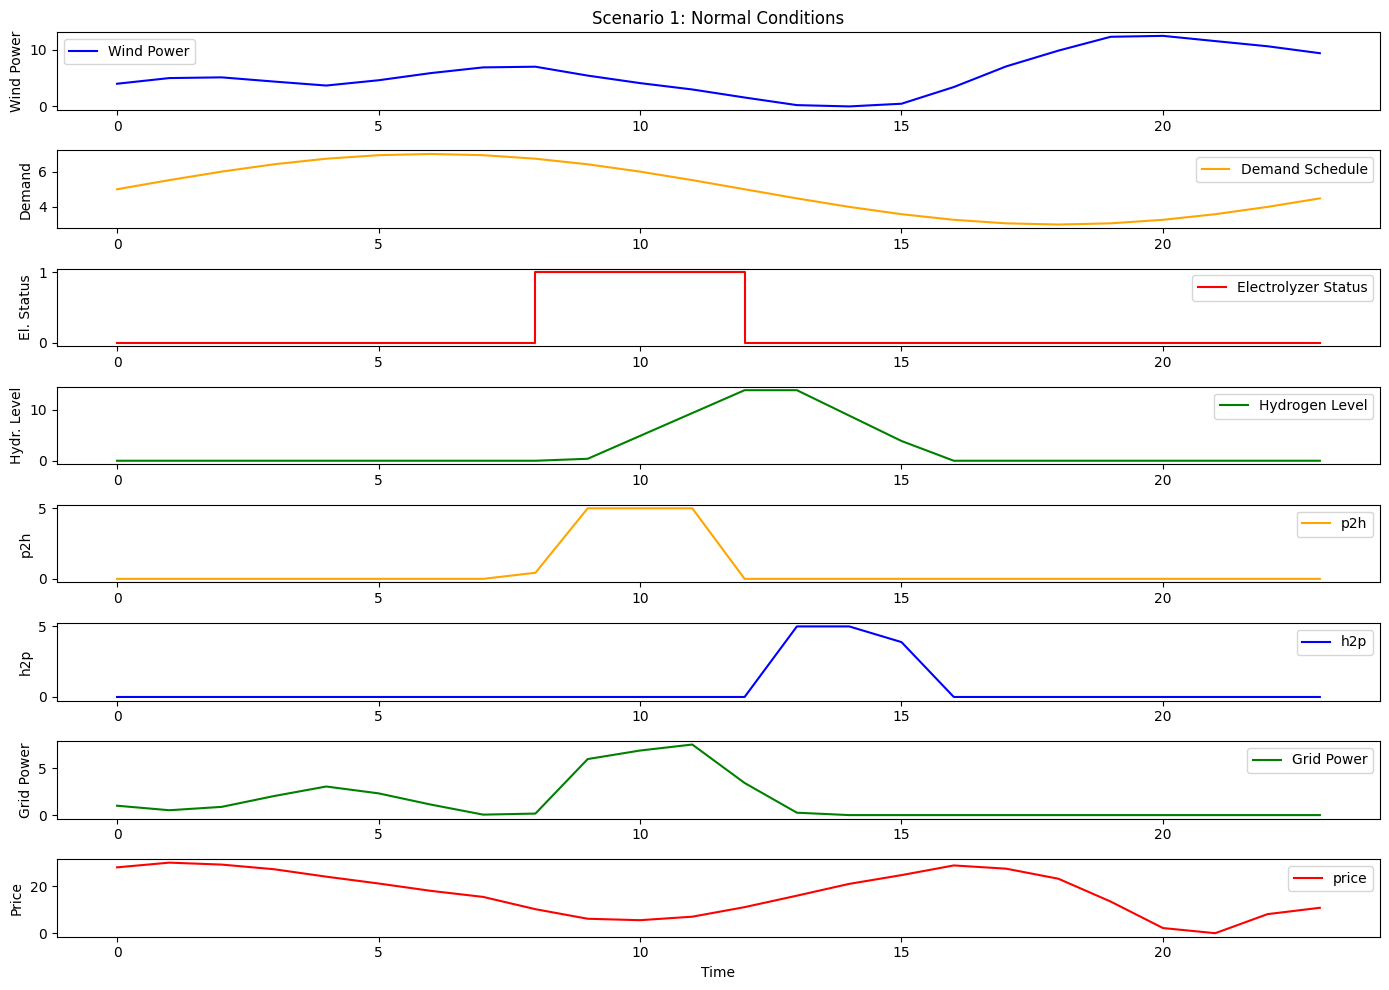

Optimal cost: 43.53


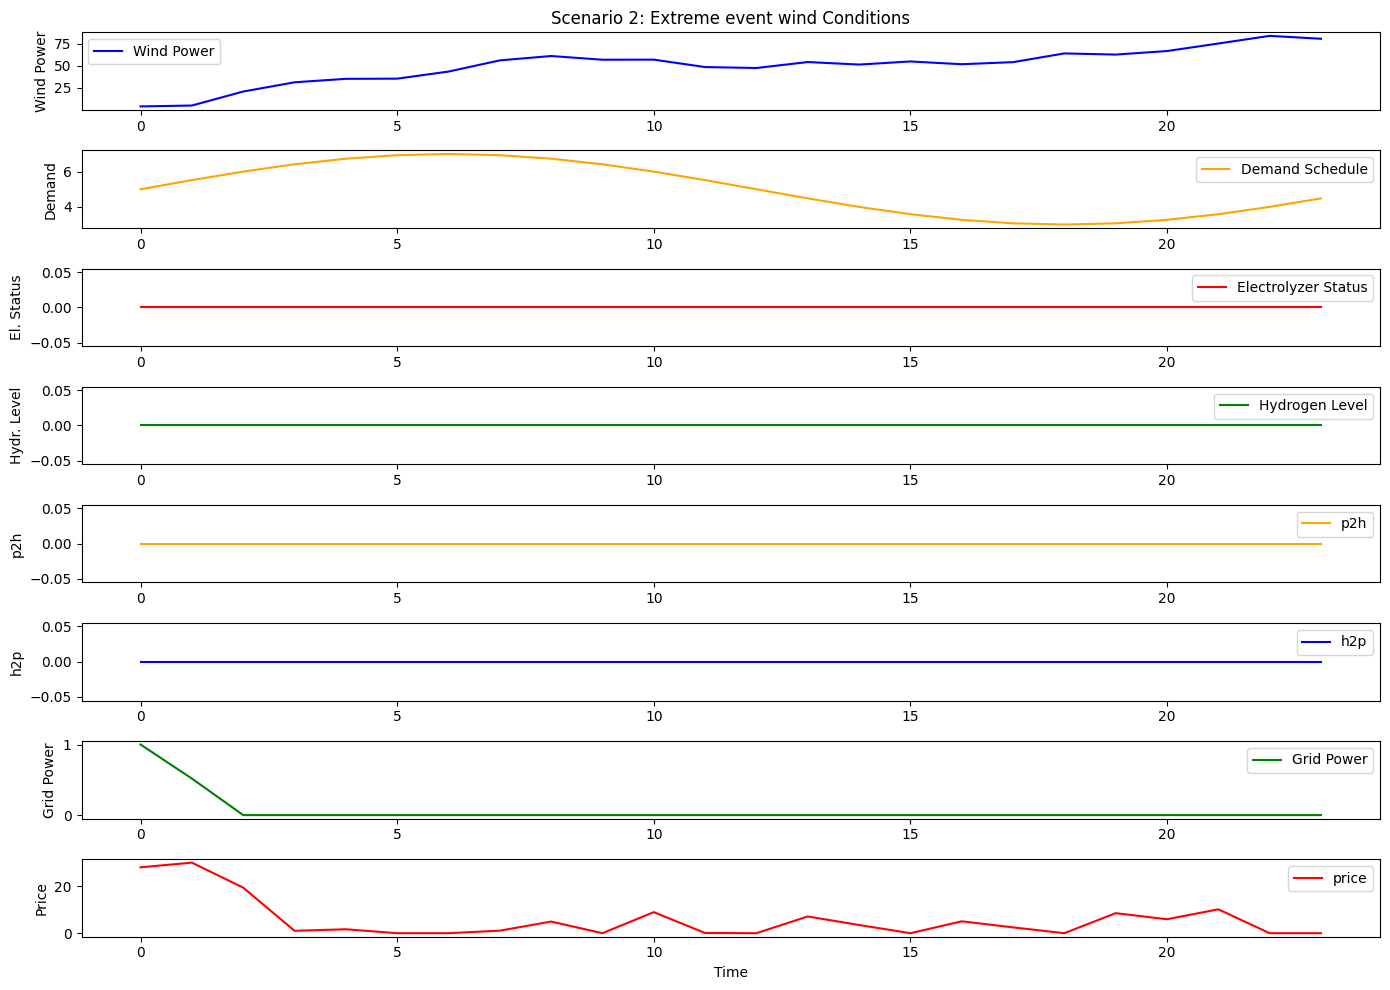

In [2]:


def main() -> None:
    data = get_fixed_data()
    
    # ============================================
    # || Task 0: Run MILP for normal conditions ||
    # ============================================
    wind1, price1 = generate_trajectories(data)
    results1 = solve_milp(wind1, price1, data, False)
    plot_results(wind1, price1, results1, data, "Scenario 1: Normal Conditions")

    # ============================================================
    # || Task 0: Run MILP for more volatile wind conditions      ||
    # ============================================================
    data_volatile = data.copy()
    data_volatile['extreme_event_prob_wind'] = 0.8

    wind2, price2 = generate_trajectories(data_volatile)
    results2 = solve_milp(wind2, price2, data, False)
    plot_results(wind2, price2, results2, data, "Scenario 2: Extreme event wind Conditions")
random.seed(1234)
main()

## Task 1: Markov Decision Process

Here we formulate our energy hub problem as a Markov Decision Process (MDP) and create a simulation environment to evaluate different decision-making policies. The MDP framework allows us to model the sequential decision-making process under uncertainty, capturing the system dynamics and state transitions. We'll implement an evaluation framework and test it with a simple dummy policy.

ENERGY HUB MDP EVALUATION

Evaluating Dummy Policy over 20 experiments...
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 530.19
Min cost: 135.74, Max cost: 1059.32
Dummy Policy Results:
Average Cost: 530.19
Min Cost: 135.74
Max Cost: 1059.32
Evaluation Time: 0.00 seconds

Generating visualizations...

Generating visualizations for Dummy Policy...


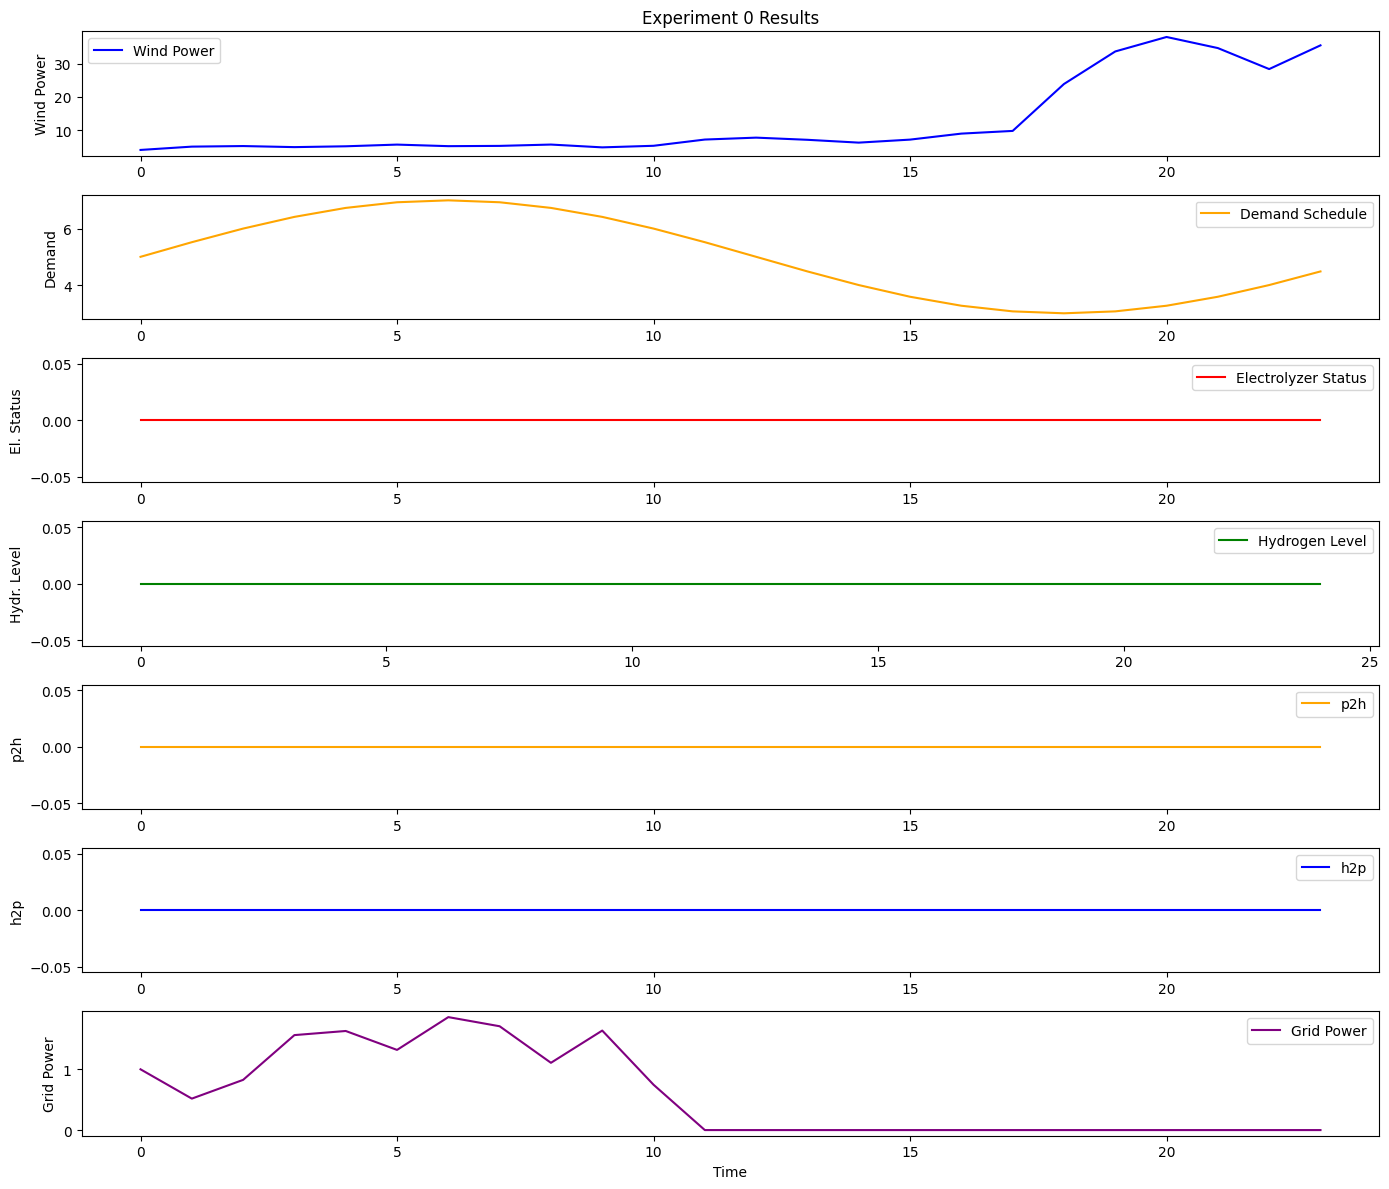

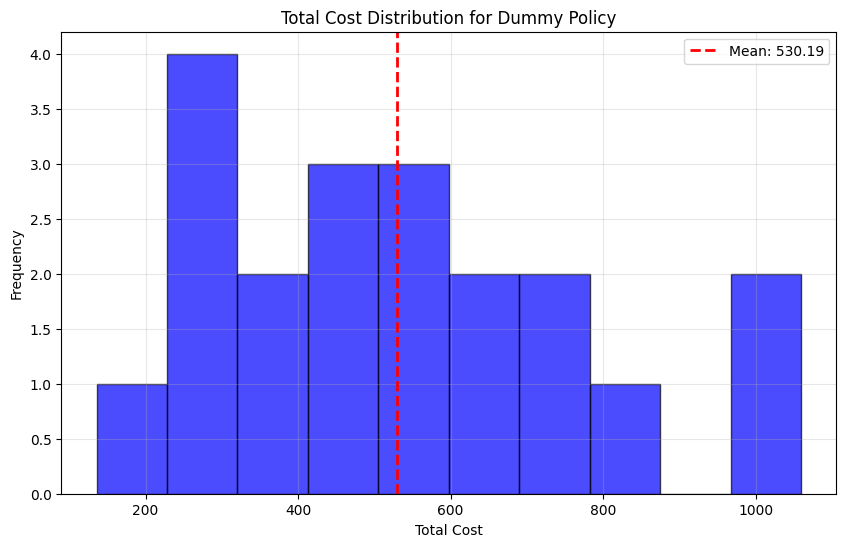


Evaluation completed successfully!


In [7]:
# ============================================================
# || Task 1: MDP Evaluation Framework                        ||
# || - Run dummy policy through MDP simulator                ||
# || - Visualize results and calculate performance metrics   ||
# ============================================================
def main():
    data = get_fixed_data()
    
    print("=" * 50)
    print("ENERGY HUB MDP EVALUATION")
    print("=" * 50)
    num_experiments = 20
    policy_results = {}
    policies = {
        "Dummy Policy": dummy_policy
    }
    expers, wind_trajectories, price_trajectories = create_experiments(num_experiments, data)
    # Evaluate each policy
    for policy_name, policy_func in policies.items():
        print(f"\nEvaluating {policy_name} over {num_experiments} experiments...")
        start_time = time.time()
        
        avg_cost, results = evaluate_policy(policy_func,data, expers, wind_trajectories, price_trajectories, num_experiments, _debug=True)
        #avg_cost, results = evaluate_policy(policy_func, num_experiments=num_experiments)
        
        elapsed_time = time.time() - start_time
        
        print(f"{policy_name} Results:")
        print(f"Average Cost: {avg_cost:.2f}")
        print(f"Min Cost: {np.min(results['total_costs']):.2f}")
        print(f"Max Cost: {np.max(results['total_costs']):.2f}")
        print(f"Evaluation Time: {elapsed_time:.2f} seconds")
        
        # Store the results
        policy_results[policy_name] = results
    
    print("\nGenerating visualizations...")
    
    for policy_name, results in policy_results.items():
        print(f"\nGenerating visualizations for {policy_name}...")
        
        plot_experiment_results(results, experiment_index=0, data=data) # just the first experiment
        
        plot_cost_histogram(results, policy_name=policy_name) # histogram of total costs over all experiments
    
    print("\nEvaluation completed successfully!")
    
    return policy_results

if __name__ == "__main__":
    policy_results = main()

## Task 2: Stochastic Programming

This task implements a multi-stage stochastic programming approach to handle uncertainty in wind generation and electricity prices. We develop scenarios to represent possible futures and optimize decisions that work well across these scenarios. The approach incorporates lookahead horizons and scenario trees to make decisions in the face of uncertainty.

In [2]:
# =============================================================
# || Task 2: Stochastic Programming Parameter Tuning          ||
# || - Loop over lookahead horizons, branches and clustering  ||
# || - Calculate total variable counts for each configuration ||
# =============================================================
total_variables = 1000
V = 3

# Generate SP policy configurations
sp_policies = {}
for L in range(3, 6):
    for B in range(2, 10):
        if V * L * (B ** (L - 1)) > total_variables:
            print(f"Skipping: L={L}, B={B} (exceeds total variables)")
            continue
        print(f"Creating SP Policy: L={L}, B={B}")

Creating SP Policy: L=3, B=2
Creating SP Policy: L=3, B=3
Creating SP Policy: L=3, B=4
Creating SP Policy: L=3, B=5
Creating SP Policy: L=3, B=6
Creating SP Policy: L=3, B=7
Creating SP Policy: L=3, B=8
Creating SP Policy: L=3, B=9
Creating SP Policy: L=4, B=2
Creating SP Policy: L=4, B=3
Creating SP Policy: L=4, B=4
Skipping: L=4, B=5 (exceeds total variables)
Skipping: L=4, B=6 (exceeds total variables)
Skipping: L=4, B=7 (exceeds total variables)
Skipping: L=4, B=8 (exceeds total variables)
Skipping: L=4, B=9 (exceeds total variables)
Creating SP Policy: L=5, B=2
Skipping: L=5, B=3 (exceeds total variables)
Skipping: L=5, B=4 (exceeds total variables)
Skipping: L=5, B=5 (exceeds total variables)
Skipping: L=5, B=6 (exceeds total variables)
Skipping: L=5, B=7 (exceeds total variables)
Skipping: L=5, B=8 (exceeds total variables)
Skipping: L=5, B=9 (exceeds total variables)


In [3]:
# ============================================================
# || Task 2: Stochastic Programming Policy Implementation    ||
# || - Configure policy parameters                           ||
# || - Run experiments with different horizon/branch configs ||
# || - Compare performance metrics across configurations     ||
# ============================================================
def main():
    data = get_fixed_data()
    
    print("=" * 70)
    print("TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT")
    print("=" * 70)
    
    num_experiments = 20
    
    policy_results = {} # store results
    ev_policy_config = create_ev_policy(horizon=3, num_samples=1000)

    total_variables = 1000
    V = 3

    # Generate SP policy configurations
    sp_policies = {}
    for L in range(3, 6):
        for B in range(2, 10):
            if V * L * (B ** (L - 1)) > total_variables:
                print(f"Skipping: L={L}, B={B} (exceeds total variables)")
                continue
            print(f"Creating SP Policy: L={L}, B={B}")
            policy_key_kmeans = f"SP Policy (H={L}, S={B}, Clustering=kmeans)"
            policy_key_kmedoids = f"SP Policy (H={L}, S={B}, Clustering=kmedoids)"
            sp_policies[policy_key_kmeans] = create_sp_policy(horizon=L, branches_per_stage=B, clustering_method='kmeans')
            sp_policies[policy_key_kmedoids] = create_sp_policy(horizon=L, branches_per_stage=B, clustering_method='kmedoids')


    # Define all policies
    policies = {
        "Dummy Policy": dummy_policy,
         "EV Policy (H=3)": ev_policy_config,
        **sp_policies,  # Add all SP policies dynamically
    }
    expers, wind_trajectories, price_trajectories = create_experiments(num_experiments, data)
    for policy_name, policy_func in policies.items():
        print(f"\n{'-' * 50}")
        print(f"Evaluating: {policy_name}")
        print(f"{'-' * 50}")
        
        start_time = time.time()
        
        try:
            avg_cost, results = evaluate_policy(policy_func, data, expers, wind_trajectories, price_trajectories, num_experiments, _debug=True)
            
            elapsed_time = time.time() - start_time
            
            print(f"\nResults for {policy_name}:")
            print(f"Average Cost: {avg_cost:.2f}")
            print(f"Min Cost: {np.min(results['total_costs']):.2f}")
            print(f"Max Cost: {np.max(results['total_costs']):.2f}")
            print(f"Standard Deviation: {np.std(results['total_costs']):.2f}")
            print(f"Evaluation Time: {elapsed_time:.2f} seconds")
            policy_results[policy_name] = results
            
        except Exception as e:
            print(f"Error evaluating {policy_name}: {e}")

if __name__ == "__main__":
    main()

TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT
Creating SP Policy: L=3, B=2
Creating SP Policy: L=3, B=3
Creating SP Policy: L=3, B=4
Creating SP Policy: L=3, B=5
Creating SP Policy: L=3, B=6
Creating SP Policy: L=3, B=7
Creating SP Policy: L=3, B=8
Creating SP Policy: L=3, B=9
Creating SP Policy: L=4, B=2
Creating SP Policy: L=4, B=3
Creating SP Policy: L=4, B=4
Skipping: L=4, B=5 (exceeds total variables)
Skipping: L=4, B=6 (exceeds total variables)
Skipping: L=4, B=7 (exceeds total variables)
Skipping: L=4, B=8 (exceeds total variables)
Skipping: L=4, B=9 (exceeds total variables)
Creating SP Policy: L=5, B=2
Skipping: L=5, B=3 (exceeds total variables)
Skipping: L=5, B=4 (exceeds total variables)
Skipping: L=5, B=5 (exceeds total variables)
Skipping: L=5, B=6 (exceeds total variables)
Skipping: L=5, B=7 (exceeds total variables)
Skipping: L=5, B=8 (exceeds total variables)
Skipping: L=5, B=9 (exceeds total variables)

---------------------------------------------

Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 557.35
Min cost: 80.05, Max cost: 1370.47

Results for EV Policy (H=3):
Average Cost: 557.35
Min Cost: 80.05
Max Cost: 1370.47
Standard Deviation: 374.30
Evaluation Time: 19.98 seconds

--------------------------------------------------
Evaluating: SP Policy (H=3, S=2, Clustering=kmeans)
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 579.27
Min cost: 74.46, Max cost: 1370.47

Results for SP Policy (H=3, S=2, Clustering=kmeans):
Average Cost: 579.27
Min Cost: 74.46
Max Cost: 1370.47
Standard Deviation: 377.78
Evaluation Time: 39.19 seconds

--------------------------------------------------
Evaluating: SP Policy (H=3, S=2, Clustering=kmedoids)
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Proce

/Users/khs/code/DMUU/.venv/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(


Processing experiment 5...
Processing experiment 10...
Hydrogen availability constraint violated: 1.7014085614537837 > 1.7014085614537788
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 12, TIMESLOT 23. THE DUMMY POLICY WILL BE USED INSTEAD
Hydrogen availability constraint violated: 1.055533235845676 > 1.055533235845673
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 13, TIMESLOT 17. THE DUMMY POLICY WILL BE USED INSTEAD
Processing experiment 15...
Hydrogen availability constraint violated: 0.46588492618038924 > 0.465884926180387
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 15, TIMESLOT 23. THE DUMMY POLICY WILL BE USED INSTEAD
Hydrogen availability constraint violated: 0.7730973458618164 > 0.7730973458618139
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 17, TIMESLOT 23. THE DUMMY POLICY WILL BE USED INSTEAD
Hydrogen availability constraint violated: 2.056002449834712 > 0.0
DECISION DOES NOT MEET THE CONSTRAINTS FOR EXPERIMENT 19, TIMESLOT 20. THE DUMMY POL

## Task 3: Approximate Dynamic Programming

In this section, we implement an Approximate Dynamic Programming (ADP) policy. ADP addresses the "curse of dimensionality" in traditional dynamic programming by approximating the value function with a parameterized model. We'll develop feature representations, train parameters through backward recursion, and implement the policy for decision-making.

*please see the code under the folder task_3*

In [ ]:
from task_3.adp_final import adp_policy
from task_3.theta_visuals import plot_theta_values
# ============================================================
# || THIS IS DONE WHEN CALLING THE adp_policy IN NEXT CELL   ||
# || Task 3: Approximate Dynamic Programming Implementation  ||
# || - Initialize value function approximation               ||
# || - Set up feature extraction for state representation    ||
# || - Implement backward recursion for parameter tuning     ||
# ============================================================



## Task 4: Comparative Evaluation

This section compares the performance of all developed policies across a standardized set of 20 experiment scenarios. We evaluate the dummy policy, optimal-in-hindsight solution, various stochastic programming configurations, expected value policy, and ADP approach. The visualizations and metrics help us understand the strengths and weaknesses of each approach in managing uncertainty.

TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT

--------------------------------------------------
Evaluating: Dummy Policy
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 437.50
Min cost: 0.00, Max cost: 961.01

Results for Dummy Policy:
Average Cost: 437.50
Min Cost: 0.00
Max Cost: 961.01
Standard Deviation: 278.10
Evaluation Time: 0.00 seconds

--------------------------------------------------
Evaluating: EV Policy (H=3)
--------------------------------------------------
Processing experiment 0...
Processing experiment 5...
Processing experiment 10...
Processing experiment 15...
Average policy cost: 410.98
Min cost: 2.00, Max cost: 961.01

Results for EV Policy (H=3):
Average Cost: 410.98
Min Cost: 2.00
Max Cost: 961.01
Standard Deviation: 272.51
Evaluation Time: 19.74 seconds

--------------------------------------------------
Eva

/Users/khs/code/DMUU/utils/visualization.py:365: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



Task 2 evaluation completed successfully!


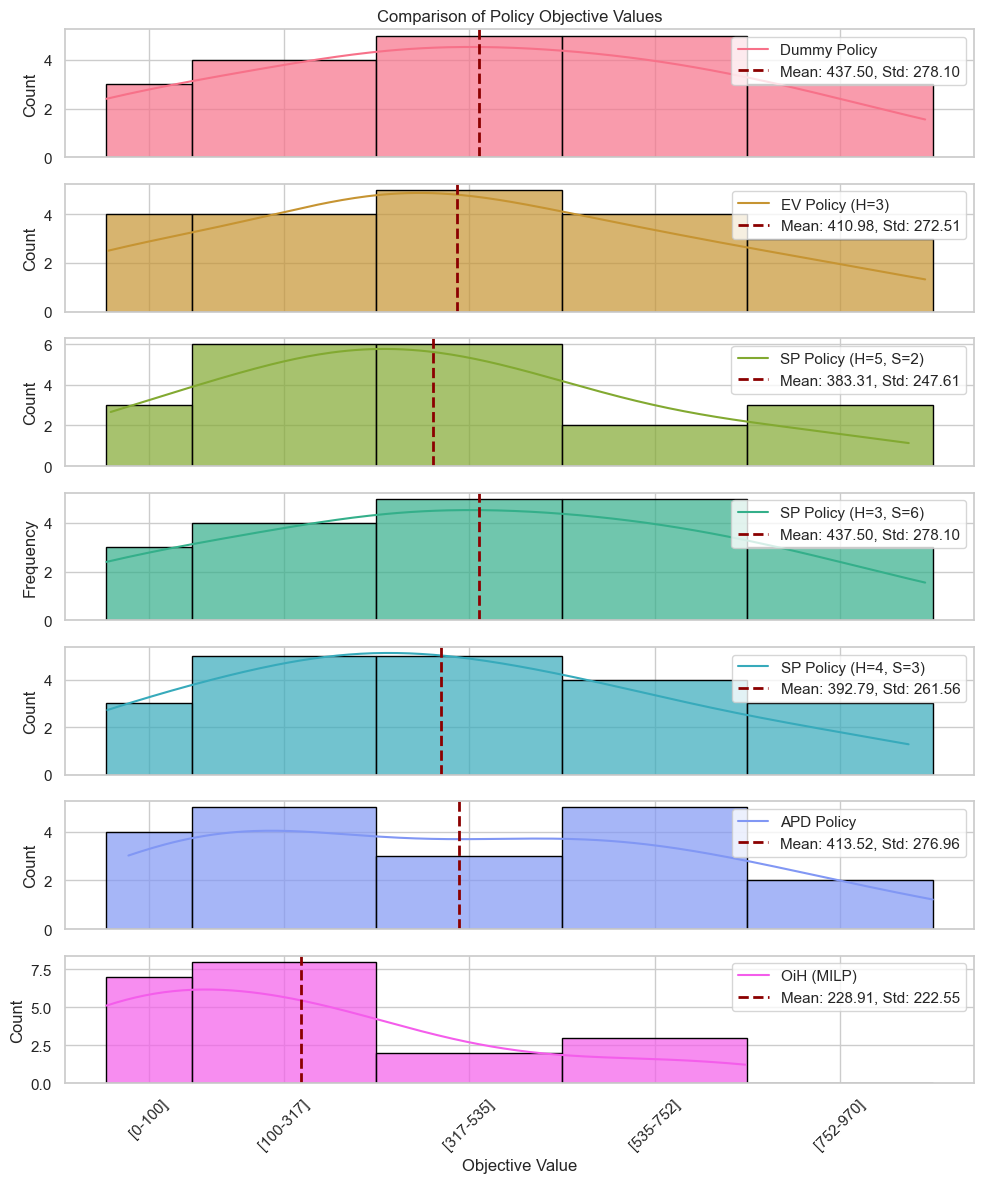

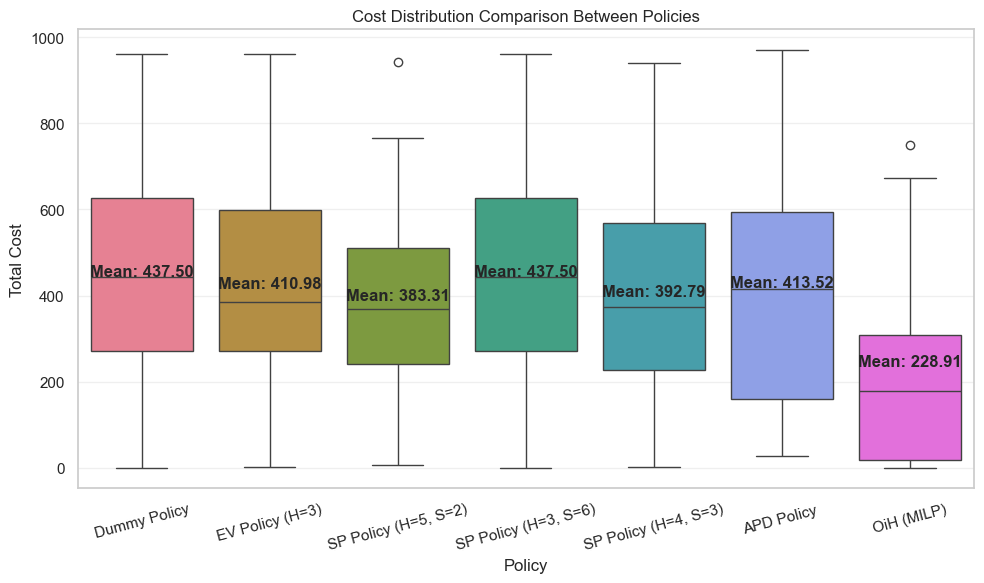

In [1]:
# ============================================================
# || Task 4: Comprehensive Policy Evaluation                 ||
# || - Run all policies on same 20 experiment scenarios      ||
# || - Calculate performance metrics for each policy         ||
# || - Generate comparison visualizations                    ||
# ============================================================
def main():
    data = get_fixed_data()
    
    print("=" * 70)
    print("TASK 2: STOCHASTIC PROGRAMMING POLICIES FOR ENERGY HUB MANAGEMENT")
    print("=" * 70)
    
    # Is this enough?
    num_experiments = 20
    
    policy_results = {} # store results
    oih_results = {}
    # Total variables ≈ V × L × B^(L-1)×2
    # V = Number of variable types (in this case, 5 main decision variables)
    # L = Lookahead horizon length
    # B = Number of branches at each stage
    # 2 = Number of uncertain parameters (wind and price)
    ev_policy_config = create_ev_policy(horizon=3, num_samples=1000)
    sp_policy_config1 = create_sp_policy(horizon=5, branches_per_stage=2)   # (800)
    sp_policy_config2 = create_sp_policy(horizon=3, branches_per_stage=6)   # (750)
    sp_policy_config3 = create_sp_policy(horizon=4, branches_per_stage=3)   # (1080) 

    policies = {
        "Dummy Policy": dummy_policy,
       "EV Policy (H=3)": ev_policy_config,
       "SP Policy (H=5, S=2)": sp_policy_config1,
       "SP Policy (H=3, S=6)": sp_policy_config2,
       "SP Policy (H=4, S=3)": sp_policy_config3,
        "APD Policy ": adp_policy_final,
    }
    expers, wind_trajectories, price_trajectories = create_experiments(num_experiments, data)
    for policy_name, policy_func in policies.items():
        print(f"\n{'-' * 50}")
        print(f"Evaluating: {policy_name}")
        print(f"{'-' * 50}")
        
        start_time = time.time()
        
        try:
            avg_cost, results = evaluate_policy(policy_func, data, expers, wind_trajectories, price_trajectories, num_experiments, _debug=True)
            
            elapsed_time = time.time() - start_time
            
            print(f"\nResults for {policy_name}:")
            print(f"Average Cost: {avg_cost:.2f}")
            print(f"Min Cost: {np.min(results['total_costs']):.2f}")
            print(f"Max Cost: {np.max(results['total_costs']):.2f}")
            print(f"Standard Deviation: {np.std(results['total_costs']):.2f}")
            print(f"Evaluation Time: {elapsed_time:.2f} seconds")
            policy_results[policy_name] = results
            
        except Exception as e:
            print(f"Error evaluating {policy_name}: {e}")
    


    # Solve MILP for OiH results
    print("\nSolving MILP for OiH results...")
    for i in range(num_experiments):
        try:
            oih_cost = solve_milp(wind_trajectories[i], price_trajectories[i], data, True)
            oih_results[i] = oih_cost
            oih_total_costs = list(oih_results.values())
            policy_results["OiH (MILP)"] = {
                "total_costs": np.array(oih_total_costs),
                "details": oih_results
            }
            
            print("\nResults for OiH (MILP):")
            print(f"Average Cost: {np.mean(oih_total_costs):.2f}")
            print(f"Min Cost: {np.min(oih_total_costs):.2f}")
            print(f"Max Cost: {np.max(oih_total_costs):.2f}")
            print(f"Standard Deviation: {np.std(oih_total_costs):.2f}")
        except Exception as e:
            print(f"Error solving MILP for experiment {i}: {e}")
    


    # ============================================================
    # || Visualization: Generate comparative policy histograms   ||
    # || - Plot cost distributions across all experiments        ||
    # || - Display mean, min, max and standard deviation         ||
    # ============================================================
    # Here claude.ai is used to write the visualizations
    if policy_results:
        print("\nGenerating visualizations...")
        
        # # Generate individual policy visualizations
        # for policy_name, results in policy_results.items():
        #     if policy_name == "OiH (MILP)":
        #         continue
        #     print(f"\nVisualizing results for {policy_name}...")

        #     # Plot results for a single experiment
        #     plot_experiment_results(results, experiment_index=0, data=data)
            
        #     # Plot histogram of costs across all experiments
        #     plot_cost_histogram(results, policy_name=policy_name)
        
            # # Identify the experiment with the highest and lowest costs
            # costs = [experiment[0] for experiment in results]
            # highest_cost_index = costs.index(max(costs))
            # lowest_cost_index = costs.index(min(costs))
            
            # # Plot the experiment with the highest cost
            # print(f"\nPlotting experiment with the highest cost for {policy_name}...")
            # plot_experiment_results(results, experiment_index=highest_cost_index, data=data)
            
            # # Plot the experiment with the lowest cost
            # print(f"\nPlotting experiment with the lowest cost for {policy_name}...")
            # plot_experiment_results(results, experiment_index=lowest_cost_index, data=data)
        
        # Compare all policies if we have more than one
        if len(policy_results) > 1:
            print("\nGenerating comparison across all policies...")
            compare_policies(policy_results)
        
        print("\nTask 2 evaluation completed successfully!")
        
        # Return the results dictionary for further analysis if needed
        return policy_results
    else:
        print("\nNo policy evaluation results available.")
        return None


policy_results = main()

In [ ]:
compare_policies(policy_results)

# Extra
## Extraction theta values

In [1]:
# ============================================================
# || Extract and visualize ADP theta parameters             ||
# || - Load trained parameter values                        ||
# || - Plot is done with task_3/theta_visuals.py            ||
# ============================================================
with open('/Users/khs/code/DMUU/task_3/trained_theta_list.pkl', 'rb') as f:
    trained_theta_list = pickle.load(f)
trained_theta_list

[array([-7.22431002e+02,  4.52642783e+01,  4.05594574e+00, -1.37133005e+00,
         2.20312534e+01,  1.02578683e+00,  4.40115920e-01, -1.37133005e+00,
        -1.30235525e+00, -6.79292228e-01, -2.87280331e+01,  1.23127984e+02]),
 array([-5.23079663e+02,  3.33283362e+01, -8.16851740e-01,  3.26724552e+00,
         6.25026637e+00,  8.41584723e-01,  7.65675525e-01,  3.26724552e+00,
        -5.80084737e-01, -2.29303571e-01, -4.63731211e+01,  0.00000000e+00]),
 array([-4.93951238e+02,  3.30768932e+01, -9.78705899e-01,  6.19024413e+00,
         8.68629347e+00,  5.10262946e-01,  3.85694751e-01,  6.19024413e+00,
        -7.13459393e-01, -2.58668647e-02, -5.12318403e+01,  7.85657447e-01]),
 array([-3.68597834e+02,  2.19284327e+01, -3.19379881e+00, -9.79029388e-01,
         3.02730178e+00,  4.35190489e-01,  6.51077242e-01, -9.79029388e-01,
        -1.42000349e-01, -1.02980142e-01, -5.64071818e+01,  0.00000000e+00]),
 array([-3.12078535e+02,  1.90207497e+01, -5.80357137e+00, -5.27427477e+00,
    